In [2]:
!pip install openpyxl

In [23]:
# File
path = "/Users/rheabarot/us_6digitnaics_rcptsize_2022.xlsx"  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel(path, engine="openpyxl")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32202 entries, 0 to 32201
Data columns (total 11 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                           --------------  ----- 
 0   The Number of Firms and Establishments, Employment, Annual Payroll, and Receipts by Industry and Enterprise Receipts Size: 2022  32202 non-null  object
 1   Unnamed: 1                                                                                                                       32201 non-null  object
 2   Unnamed: 2                                                                                                                       32201 non-null  object
 3   Unnamed: 3                                                                                           

In [16]:
# Reload + standardize columns
import pandas as pd
import numpy as np

def load_with_header_guess(xlsx_path, try_rows=(0,1,2,3,4)):
    """Try multiple header rows; pick the one with the most non-'Unnamed' columns."""
    best_df, best_score, best_h = None, -1, None
    for h in try_rows:
        t = pd.read_excel(xlsx_path, header=h, engine="openpyxl")
        non_unnamed = sum(not str(c).lower().startswith("unnamed") for c in t.columns)
        score = non_unnamed
        if score > best_score:
            best_df, best_score, best_h = t, score, h
    best_df.attrs["header_row"] = best_h
    return best_df

df = load_with_header_guess(path)
print(f"Detected header row: {df.attrs.get('header_row')}")
df = df.dropna(axis=1, how="all")
df.columns = [str(c).strip() for c in df.columns]

# Possible headers + tidying names
rename_map = {}
for c in df.columns:
    lc = c.lower()
    if ("naics" in lc) and ("label" in lc):
        rename_map[c] = "industry"                # industry label
    elif "naics" in lc:
        rename_map[c] = "naics"                   # 6-digit code
    elif ("receipt" in lc) and ("size" not in lc):
        rename_map[c] = "receipts"                # dollar amount
    elif ("enterprise receipts size" in lc) or ("rcptsize" in lc) or ("receipt size" in lc):
        rename_map[c] = "receipt_size_bucket"
    elif ("emp_size" in lc) or ("employment size" in lc) or ("firm size" in lc):
        rename_map[c] = "firm_size"
    elif ("employment" in lc) or (lc.strip() == "emp"):
        rename_map[c] = "employment"
    elif ("payroll" in lc):
        rename_map[c] = "payroll"
    elif ("number of firms" in lc) or ("firms" in lc) or ("establishments" in lc):
        # Treat "firms" as count of firms if present
        if "firms" not in rename_map.values():
            rename_map[c] = "firms"

if rename_map:
    df = df.rename(columns=rename_map)

# Remove stray header rows accidentally read as data
df = df[~df.apply(lambda r: all(str(x).lower().startswith("unnamed") for x in r.index), axis=1)]

# Make sure data is numeric
for num_col in ["receipts", "payroll", "employment", "firms"]:
    if num_col in df.columns:
        # Only convert if it's a Series, not a DataFrame
        if isinstance(df[num_col], pd.Series):
            df[num_col] = pd.to_numeric(df[num_col], errors="coerce")

# Drop "total" rows
if "industry" in df.columns:
    df = df[~df["industry"].astype(str).str.contains("total", case=False, na=False)]

# Quick look at cleaned data to check if it looks right
print("Tidy columns:", list(df.columns))
display(df.head(8))

Detected header row: 2
Tidy columns: ['naics', 'naics', 'Enterprise Size\n($1,000)', 'firms', 'Establishments', 'employment', 'employment', 'payroll', 'payroll', 'receipts', 'receipts']


,naics,naics,"Enterprise Size\n($1,000)",firms,Establishments,employment,employment,payroll,payroll,receipts,receipts
0,--,Total,01: Total,6395635,8298562,135748407,G,8965035263,G,50848996830,G
1,--,Total,02: <100,1097913,1098679,1271234,J,27913067,G,55024886,G
2,--,Total,03: 100-499,2348197,2353299,5902734,G,190023639,G,604756701,G
3,--,Total,04: 500-999,1020244,1029263,5829784,G,218146469,G,727469860,G
4,--,Total,"05: 1,000-2,499",987743,1028450,10577568,G,442875049,G,1546764969,G
5,--,Total,"06: 2,500-4,999",421142,478353,8154534,G,389902183,G,1467255380,G
6,--,Total,"07: 5,000-7,499",155200,196812,4510215,G,239417158,G,942538815,G
7,--,Total,"08: 7,500-9,999",80189,114141,3109812,G,172835750,G,692030225,G


In [17]:
# Keep only one of each duplicate column and drop flag columns (like the "G"/"J")
df = df.loc[:, ~df.columns.duplicated()].copy()

for c in df.columns:
    if df[c].astype(str).str.fullmatch(r"[A-Za-z]").any():
        df = df.drop(columns=[c])

# Clean up column names
df.columns = [c.strip().replace("\n", " ") for c in df.columns]

df.head()

,naics,"Enterprise Size ($1,000)",firms,Establishments,employment,payroll,receipts
0,--,01: Total,6395635,8298562,135748407,8965035263,50848996830
1,--,02: <100,1097913,1098679,1271234,27913067,55024886
2,--,03: 100-499,2348197,2353299,5902734,190023639,604756701
3,--,04: 500-999,1020244,1029263,5829784,218146469,727469860
4,--,"05: 1,000-2,499",987743,1028450,10577568,442875049,1546764969


In [11]:
# Convert to numeric
for col in ["firms", "Establishments", "employment", "payroll", "receipts"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32200 entries, 0 to 32199
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   naics                     32200 non-null  object
 1   Enterprise Size ($1,000)  32200 non-null  object
 2   firms                     32200 non-null  int64 
 3   Establishments            32200 non-null  int64 
 4   employment                32200 non-null  int64 
 5   payroll                   32200 non-null  int64 
 6   receipts                  32200 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.7+ MB


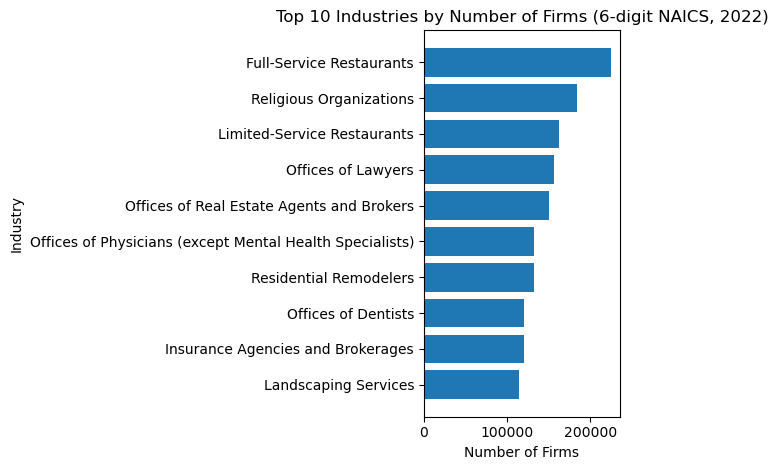

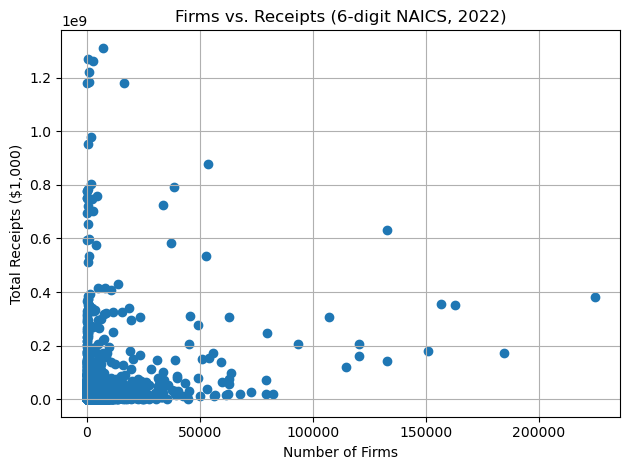

,NAICS,Industry,Receipts_per_Firm_1k
17885,452311,Warehouse Clubs and Supercenters,75089645.1
17881,452311,Warehouse Clubs and Supercenters,30037077.04
21928,522294,Secondary Market Financing,28843292.571429
5823,324110,Petroleum Refineries,14697921.566038
21634,521110,Monetary Authorities-Central Bank,13567504.538462
11359,336112,Light Truck and Utility Vehicle Manufacturing,12900440.777778
5820,324110,Petroleum Refineries,11291858.913043
21633,521110,Monetary Authorities-Central Bank,10375446.705882
16429,444110,Home Centers,6849677.974359
11352,336111,Automobile Manufacturing,5789441.208333


In [30]:
# 3 Questions + Visuals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

PATH = "/Users/rheabarot/us_6digitnaics_rcptsize_2022.xlsx" 

def _coerce_num(s):
    return pd.to_numeric(
        pd.Series(s, dtype="string").str.replace(",","", regex=False).str.replace("$","", regex=False),
        errors="coerce"
    )

# Reading file
def load_naics(path):
    df = None
    try:
        df = pd.read_excel(path, header=None)
    except Exception:
        try:
            df = pd.read_html(path)[0]
        except Exception:
            df = pd.read_csv(path, sep=None, engine="python", header=None)

    # Headers
    cols_str = [str(c).strip() for c in df.iloc[0].tolist()]
    # If first row includes NAICS headers, use it
    if ("NAICS" in cols_str) and any("NAICS Description" in c for c in cols_str):
        df.columns = cols_str
        df = df.iloc[1:].reset_index(drop=True)
    else:
        # Search for the header row where first 2 columns look like NAICS / NAICS Description
        hdr_idx = None
        for i in range(min(len(df), 50)):  # scan top 50 rows
            row = [str(x).strip() for x in df.iloc[i].tolist()]
            if "NAICS" in row and any("NAICS Description" in c for c in row):
                hdr_idx = i
                break
        if hdr_idx is None:
            hdr_idx = 0
        df.columns = [str(c).strip() for c in df.iloc[hdr_idx].tolist()]
        df = df.iloc[hdr_idx+1:].reset_index(drop=True)

    # Normalize column names 
    df.columns = [str(c).strip() for c in df.columns]

    # Keep only the columns needed
    def pick(name_options):
        for nm in df.columns:
            for opt in name_options:
                if opt.lower() in nm.lower():
                    return nm
        return None

    col_naics = pick(["NAICS"])
    col_desc  = pick(["NAICS Description"])
    col_firms = pick(["Firms"])
    col_recv  = pick(["Receipts ($1,000)", "Receipts"])

    need = [col_naics, col_desc, col_firms, col_recv]
    if any(c is None for c in need):
        raise KeyError(f"Missing expected columns. Found: {df.columns.tolist()[:15]}")

    # Filter to 6-digit NAICS rows only
    df = df[df[col_naics].astype(str).str.fullmatch(r"\d{6}", na=False)]

    # Coerce numerics
    df[col_firms] = _coerce_num(df[col_firms])
    df[col_recv]  = _coerce_num(df[col_recv])

    # Clean and return slim frame
    out = df[[col_naics, col_desc, col_firms, col_recv]].dropna(subset=[col_firms])
    out.columns = ["NAICS","Industry","Firms","Receipts_1k"]
    return out

df = load_naics(PATH)


# Q1. Which industries account for the most small businesses in 2022?
top10 = df.sort_values("Firms", ascending=False).head(10)

plt.figure()
plt.barh(top10["Industry"], top10["Firms"])
plt.xlabel("Number of Firms")
plt.ylabel("Industry")
plt.title("Top 10 Industries by Number of Firms (6-digit NAICS, 2022)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Q2. Are industries with more small firms also generating higher receipts?
plt.figure()
plt.scatter(df["Firms"], df["Receipts_1k"])
plt.xlabel("Number of Firms")
plt.ylabel("Total Receipts ($1,000)")
plt.title("Firms vs. Receipts (6-digit NAICS, 2022)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Q3. Which industries have the highest average receipts per small business?
df_eff = df.copy()
df_eff["Receipts_per_Firm_1k"] = df_eff["Receipts_1k"] / df_eff["Firms"]
df_eff = df_eff.sort_values("Receipts_per_Firm_1k", ascending=False)

# Display top 10 table
df_eff[["NAICS","Industry","Receipts_per_Firm_1k"]].head(10)

In [14]:
# Q2: Inside the small-business segment (< $1M receipts), which buckets contribute most to firms, receipts, employment, and payroll?

import pandas as pd

df_q2 = df.copy()
df_q2 = df_q2[~df_q2["Enterprise Size ($1,000)"].astype(str).str.contains("Total", case=False, na=False)].copy()
df_q2["bucket"] = (
    df_q2["Enterprise Size ($1,000)"].astype(str)
         .str.replace(r"^\s*\d+\s*:\s*", "", regex=True)
         .str.strip()
)

small_buckets = {"<100", "100-499", "500-999"}  # <$1M
df_q2 = df_q2[df_q2["bucket"].isin(small_buckets)].copy()

q2 = (
    df_q2.groupby("bucket", as_index=False)[["firms","receipts","employment","payroll"]]
         .sum()
         .sort_values("receipts", ascending=False)
)

print("\nQ2: Contribution by bucket within SMALL BUSINESSES (< $1M receipts)\n")
display(q2)

q2.to_csv("Q2_small_business_bucket_contributions.csv", index=False)


Q2: Contribution by bucket within SMALL BUSINESSES (< $1M receipts)



,bucket,firms,receipts,employment,payroll
1,500-999,6125256,4362769680,34970791,1308523536
0,100-499,14081188,3625645731,35399876,1139634393
2,<100,6571889,329483427,7616435,167183537


In [19]:
# Q3: How do productivity metrics (receipts/firm, receipts/employee, payroll/employee) compare for small (< $1M receipts) vs large (>= $1M) businesses.

import pandas as pd
import numpy as np

df_q3 = df.copy()
df_q3 = df_q3[~df_q3["Enterprise Size ($1,000)"].astype(str).str.contains("Total", case=False, na=False)].copy()
df_q3["bucket"] = (
    df_q3["Enterprise Size ($1,000)"].astype(str)
         .str.replace(r"^\s*\d+\s*:\s*", "", regex=True)
         .str.strip()
)

small_buckets = {"<100", "100-499", "500-999"}  # <$1M
df_q3["segment"] = np.where(df_q3["bucket"].isin(small_buckets), "SMALL (<$1M)", "LARGE (≥$1M)")

# Per-unit metrics (avoid divide-by-zero)
df_q3["receipts_per_firm"]     = df_q3["receipts"] / df_q3["firms"].replace(0, pd.NA)
df_q3["receipts_per_employee"] = df_q3["receipts"] / df_q3["employment"].replace(0, pd.NA)
df_q3["payroll_per_employee"]  = df_q3["payroll"]  / df_q3["employment"].replace(0, pd.NA)

q3 = (
    df_q3.groupby("segment", as_index=False)[
        ["receipts","firms","employment","payroll","receipts_per_firm","receipts_per_employee","payroll_per_employee"]
    ]
    .mean(numeric_only=True)
    .sort_values("receipts_per_firm", ascending=False)
)

print("\nQ3: Productivity comparison — SMALL vs LARGE businesses\n")
display(q3)

q3.to_csv("Q3_productivity_small_vs_large.csv", index=False)


Q3: Productivity comparison — SMALL vs LARGE businesses



,segment,receipts,firms,employment,payroll,receipts_per_firm
0,LARGE (≥$1M),1.217792e+07,494.829721,30216.993350,2.099758e+06,60702.231751
1,SMALL (<$1M),1.425030e+06,4587.687682,13360.819256,4.480626e+05,345.331221
